---

This notebook contains code to re-create **Figure 8** from:

*Gaussian Process Modeling to Recover Faraday Depth Spectra*, 2020, Simon W. Ndiritu, Anna M. M. Scaife, David L. Tabb, Miguel Carcamo & Joe Hanson

**Note:** The flagging and noise realisations implemented in this notebook are stochastic, so the figure will have the same properties as the one that appears in the paper but is unlikely to be identical.

---

In [1]:
import autograd.numpy as np
import pylab as pl
import os,sys
import scipy.stats as ss
from tqdm import tqdm_notebook

In [2]:
from faraday_models import *
from faraday_stuff import *
from celerite_base import *

In [3]:
pl.rcParams['figure.figsize'] = [20, 5]
pl.rcParams['figure.dpi'] = 300

---
### Set up parameter space

In [4]:
const_c = 3e8  # m/s

In [5]:
channels = 300 
freq_min = 1.1e9 
freq_max = 1.4e9
freq     = np.linspace(freq_min, freq_max, channels)

l2     = (const_c/freq)**2
l2_min = (const_c/freq_max)**2
l2_max = (const_c/freq_min)**2

---
### Visualise models

The parameters of the models from Sun et al (2010) are contained in the `faraday_models.py` file. These next few cells illustrate how the model data are normalised and how the channel noise is set in order to ensure a SNR of 32 for each model.

First select a model [0-16]:

In [6]:
model = 0

In [7]:
p = make_model(model,l2)

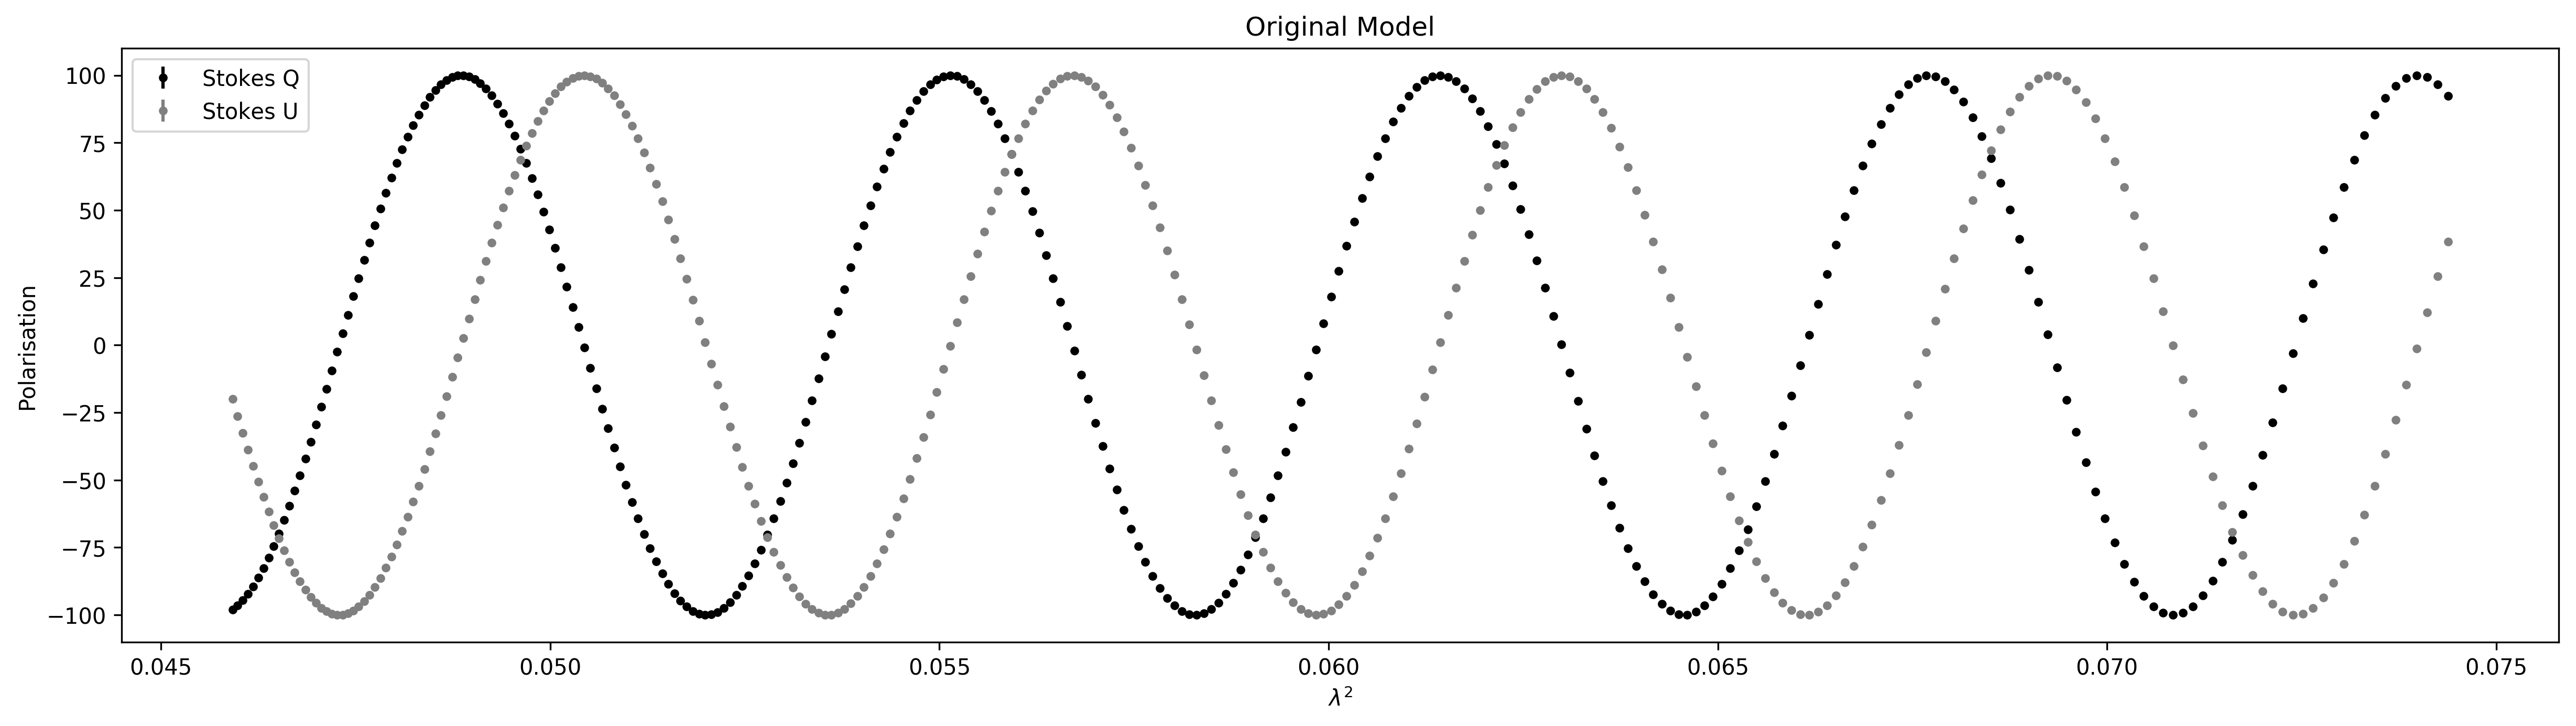

In [8]:
ax = pl.subplot(111)

ax.errorbar(l2[::-1],np.real(p)[::-1], yerr=0., fmt='.', c='black', capthick=0, label="Stokes Q")
ax.errorbar(l2[::-1],np.imag(p)[::-1], yerr=0., fmt='.', c='grey', capthick=0, label="Stokes U")

ax.set_ylabel("Polarisation")
ax.set_xlabel(r"$\lambda^2$")

ax.legend()
pl.title("Original Model")
pl.show()

Normalise the model so that a channel noise of 1 gives SNR=32:

In [40]:
pI = np.mean(np.sqrt(np.real(p)**2+np.imag(p)**2))
snr = pI*np.sqrt(len(l2))
f_snr = 32./snr
p*=f_snr

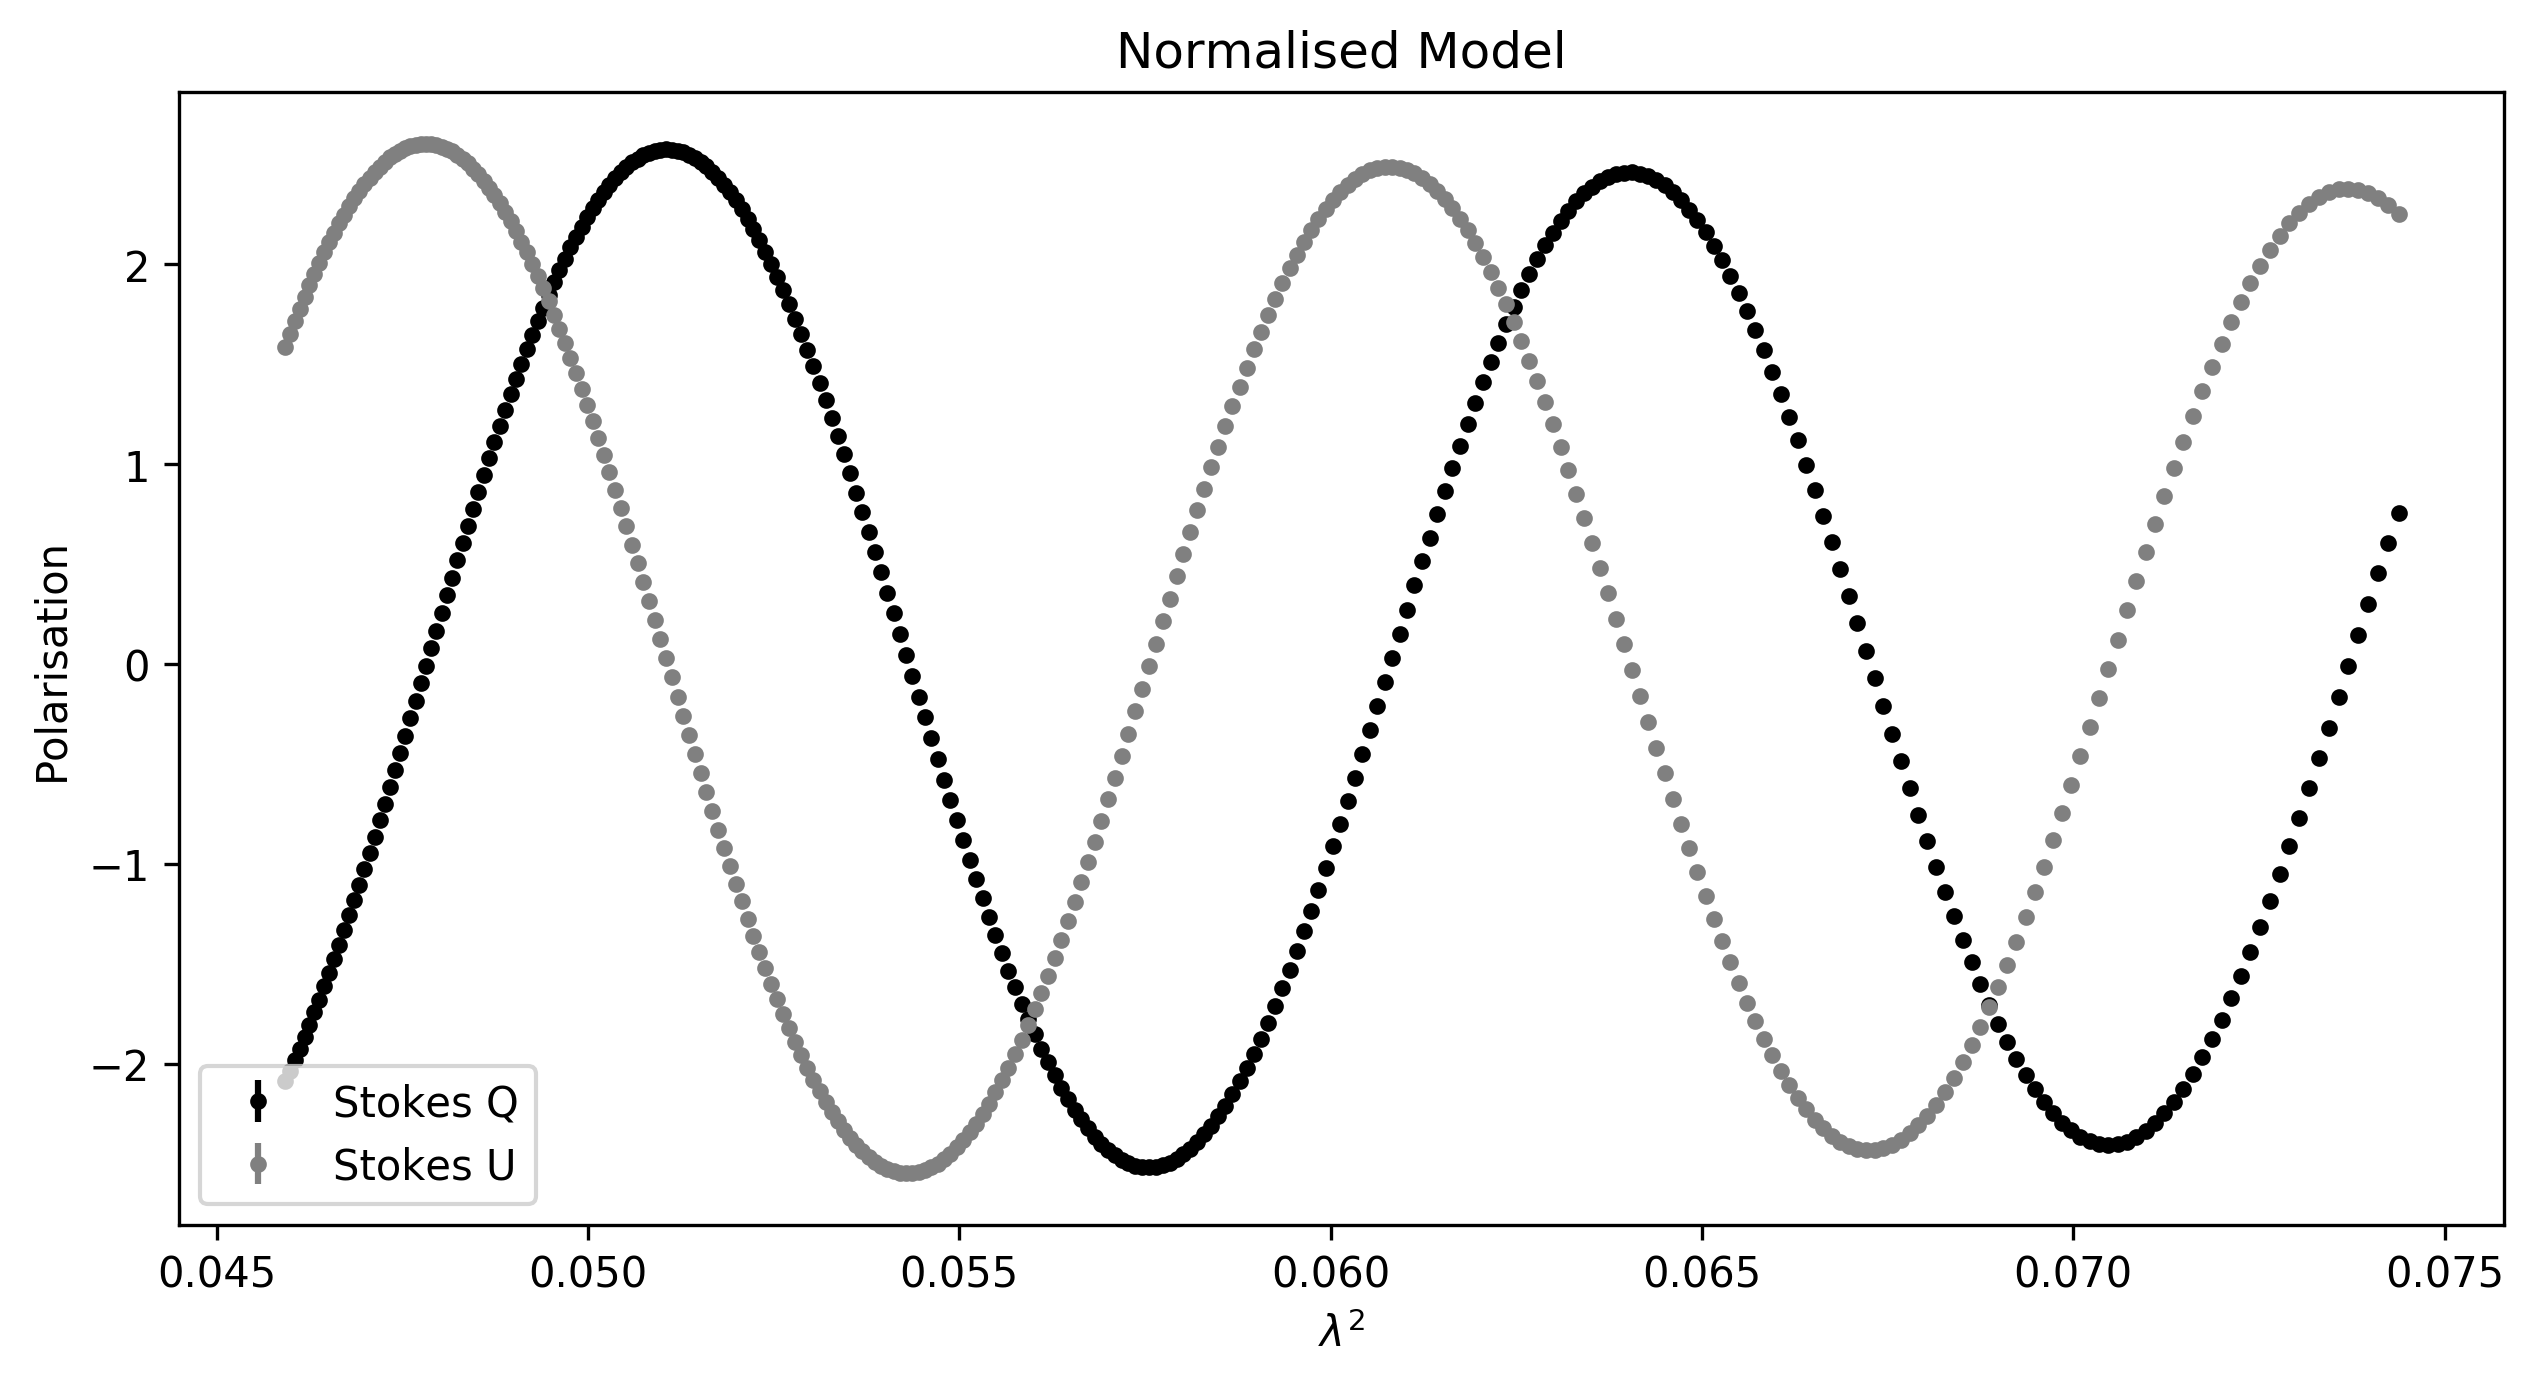

In [41]:
ax = pl.subplot(111)

ax.errorbar(l2[::-1],np.real(p)[::-1], yerr=0., fmt='.', c='black', capthick=0, label="Stokes Q")
ax.errorbar(l2[::-1],np.imag(p)[::-1], yerr=0., fmt='.', c='grey', capthick=0, label="Stokes U")

ax.set_ylabel("Polarisation")
ax.set_xlabel(r"$\lambda^2$")

ax.legend()
pl.title("Normalised Model")
pl.show()

Add noise to the model data:

In [42]:
noise = 1.0
fnoise= noise/np.sqrt(len(p))
print(fnoise)

stokesQn = np.real(p)+np.random.normal(loc =0.0, scale=noise, size = len(p))
stokesUn = np.imag(p)+np.random.normal(loc =0.0, scale=noise, size = len(p))

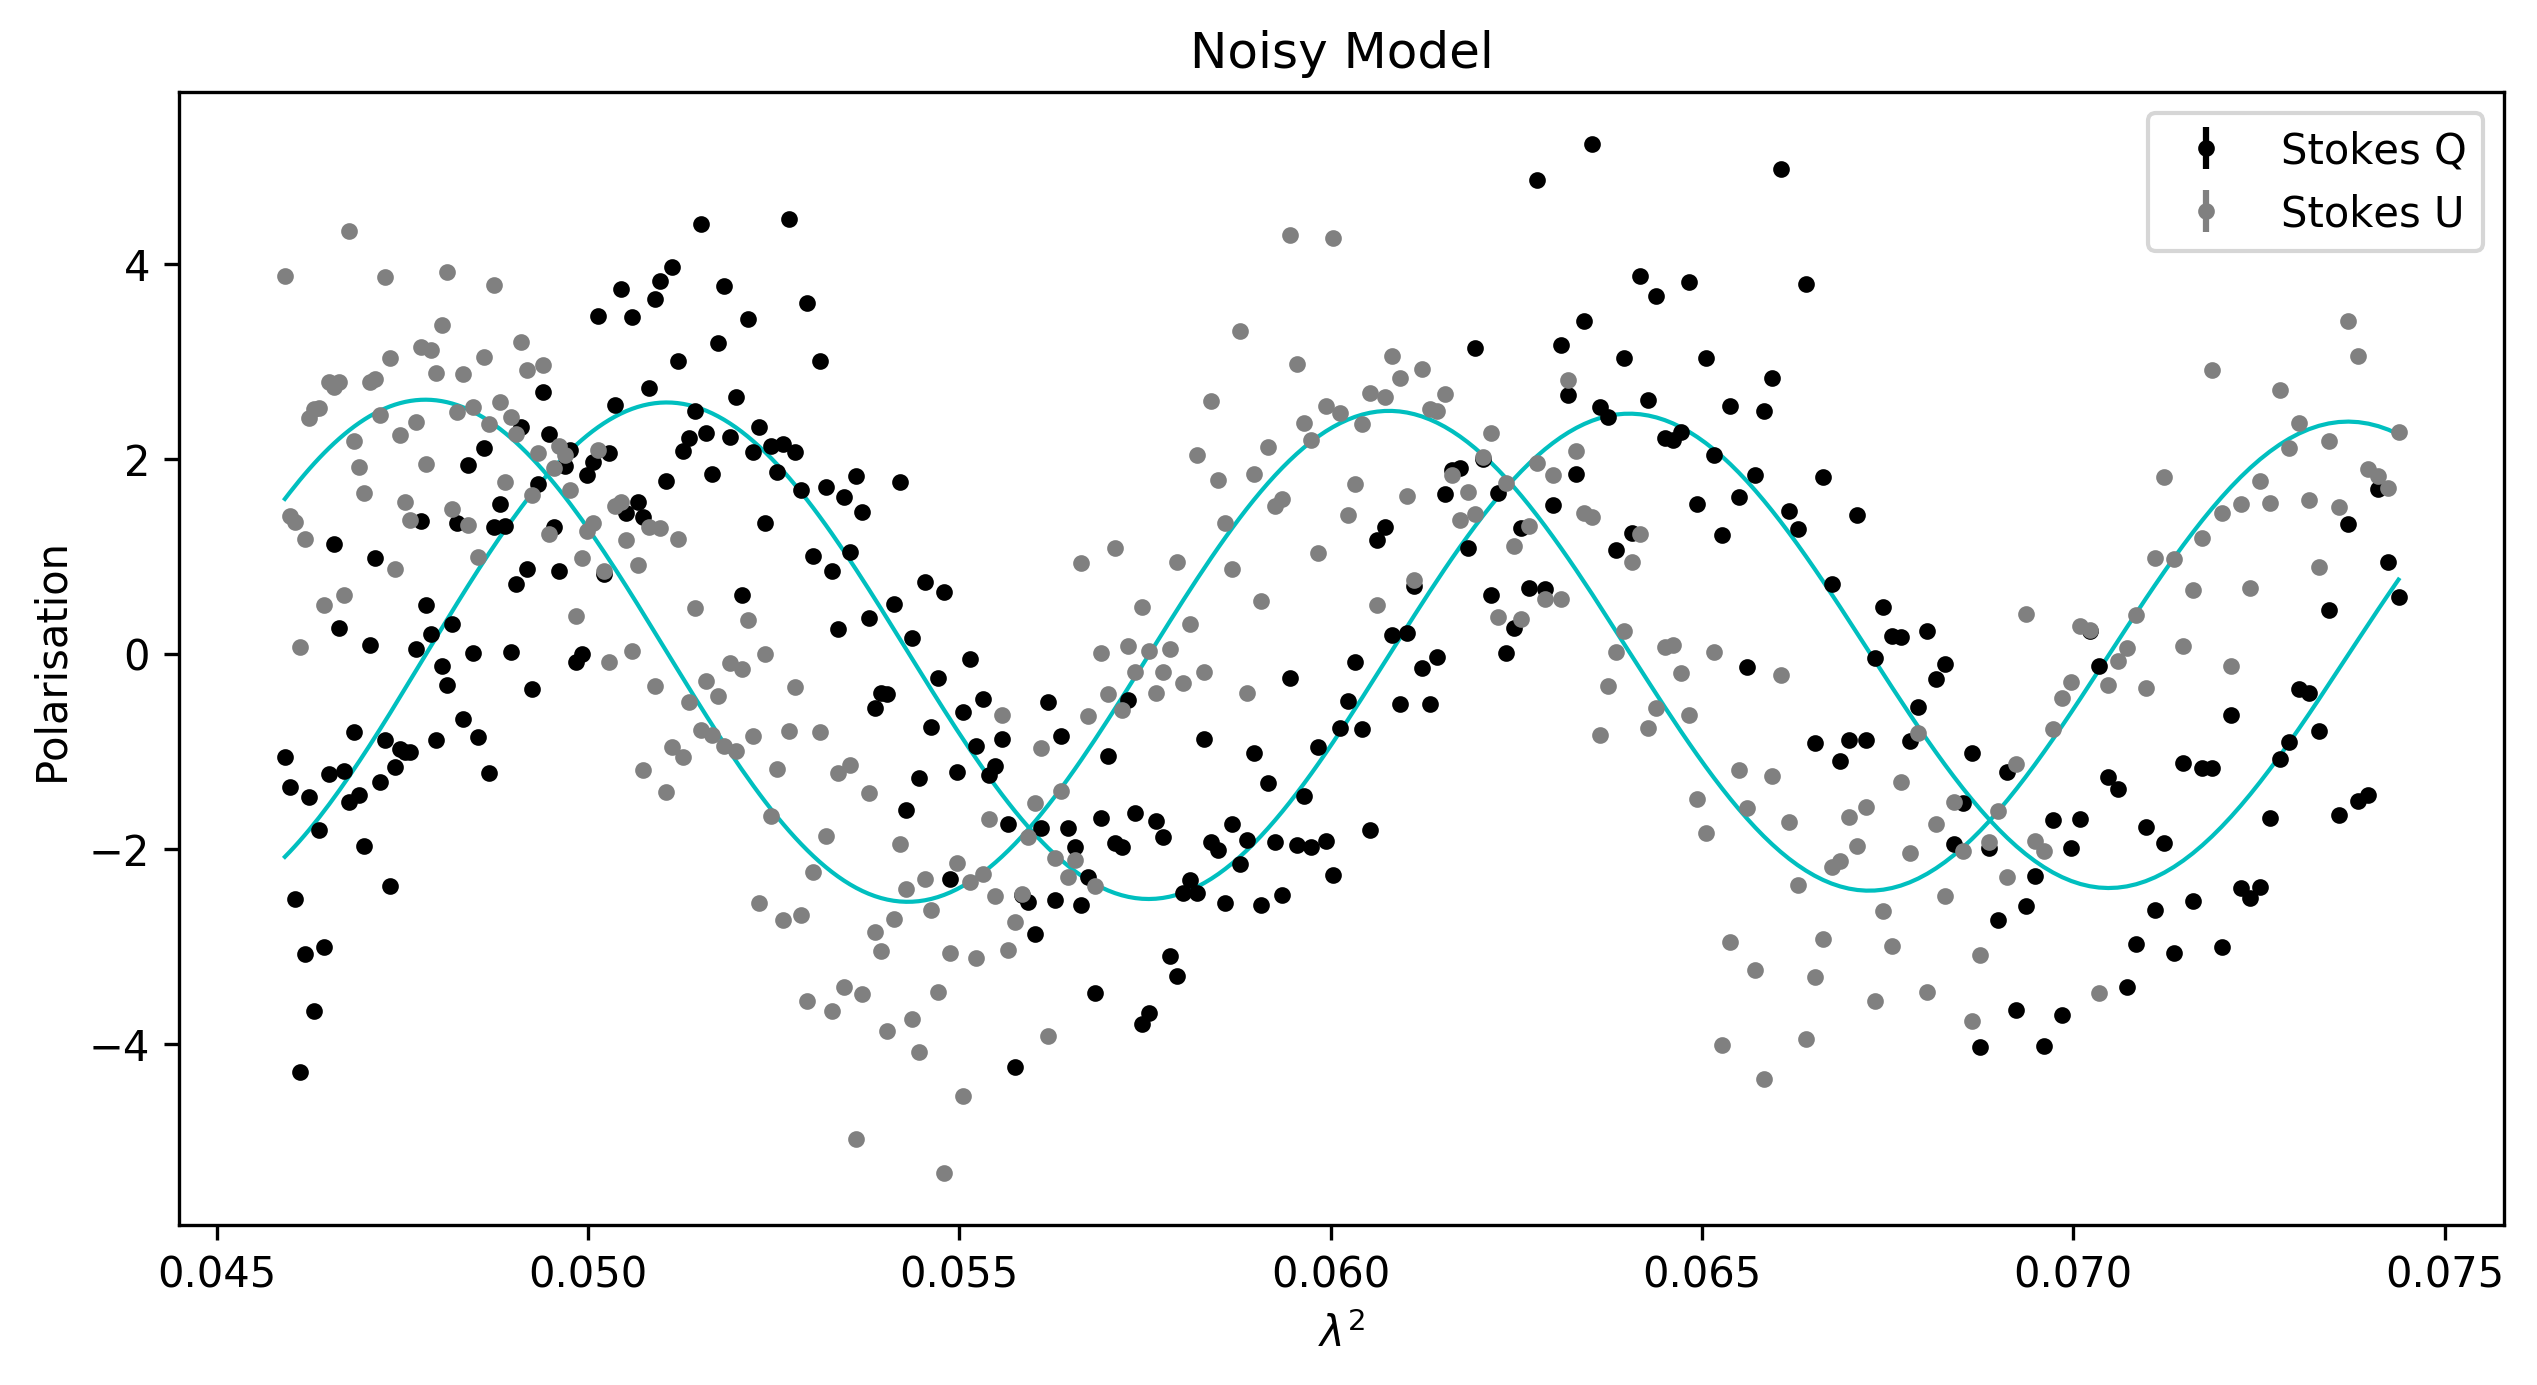

In [43]:
ax = pl.subplot(111)

ax.plot(l2,np.real(p), linestyle='-', color = 'c', lw=1.0)
ax.plot(l2,np.imag(p), color = 'c', lw=1.0)

ax.errorbar(l2,stokesQn, yerr=0., fmt='.', c='black', capthick=0, label="Stokes Q")
ax.errorbar(l2,stokesUn, yerr=0., fmt='.', c='grey', capthick=0, label="Stokes U")

ax.set_ylabel("Polarisation")
ax.set_xlabel(r"$\lambda^2$")

ax.legend()
pl.title("Noisy Model")
pl.show()

In [13]:
# optimize hyper-parameters of GP and make a prediction:
GP = MyCelerite(noise)
GP.celerite_optimize(l2, stokesQn, stokesUn)
mu_q, std_q, mu_u, std_u = GP.celerite_predict(stokesQn, stokesUn, l2[::-1])

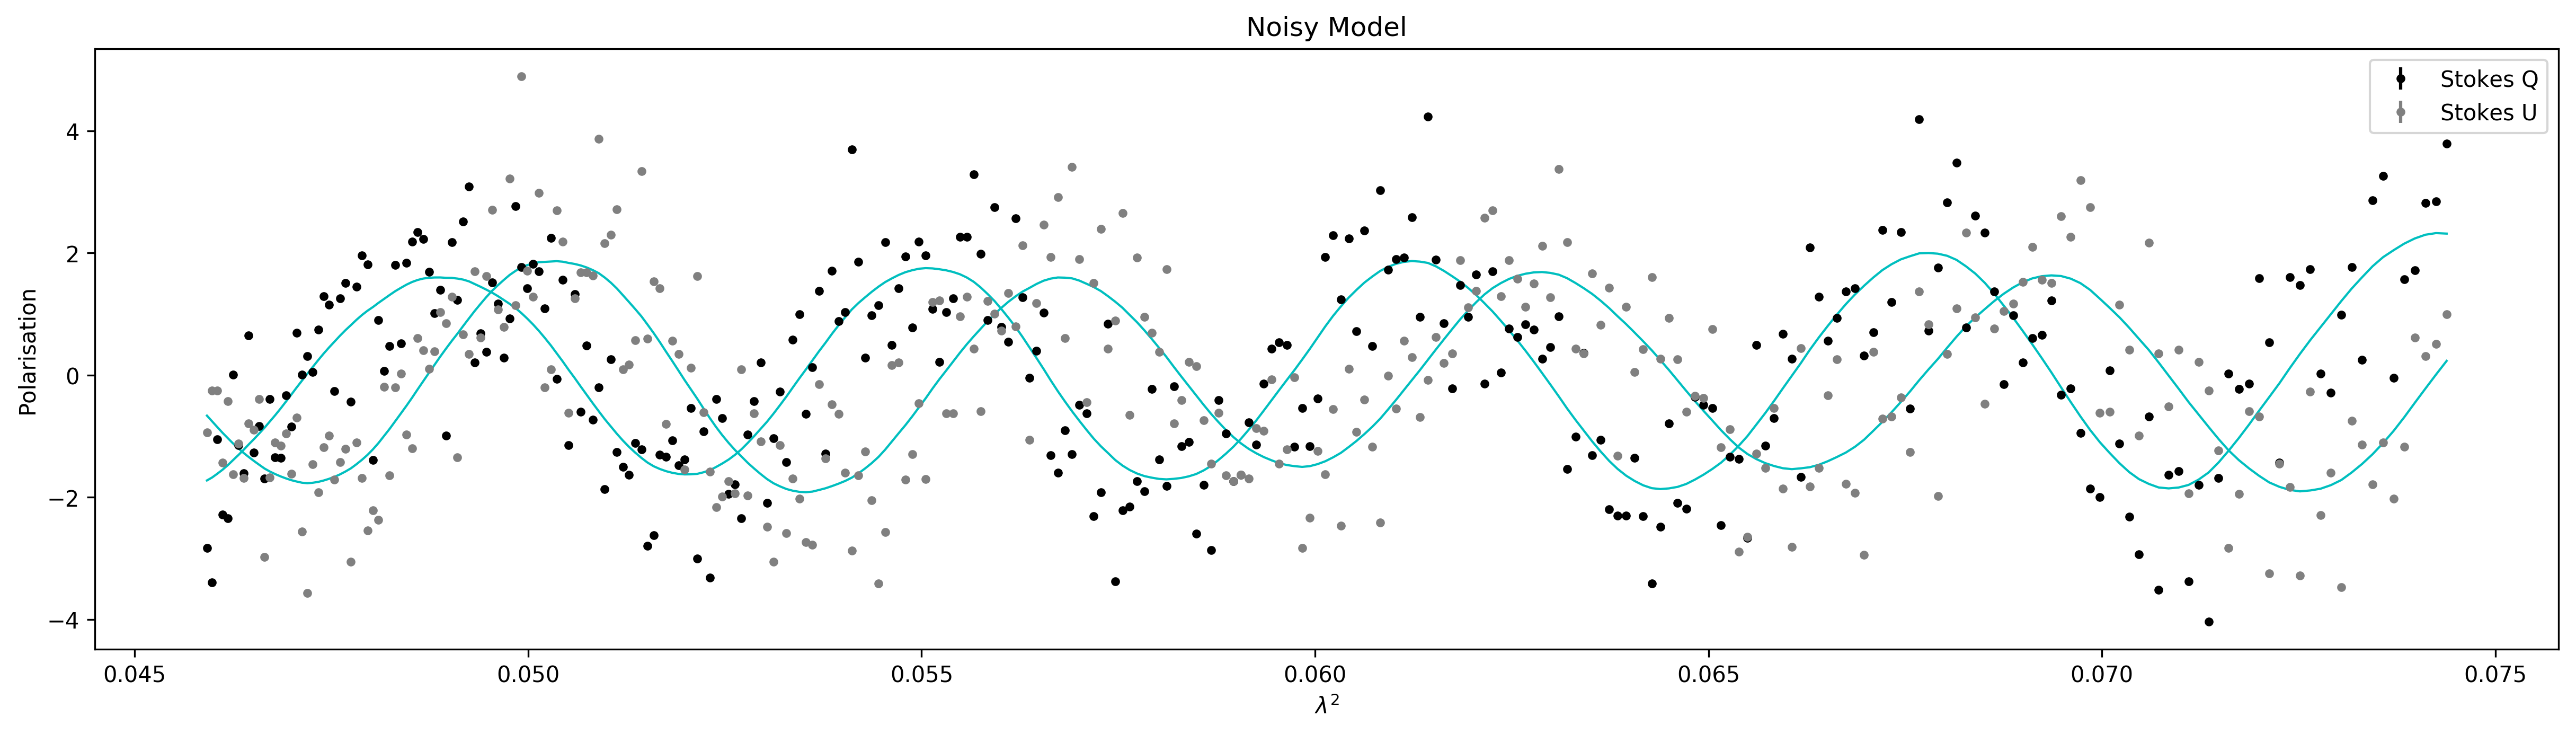

In [14]:
ax = pl.subplot(111)

ax.plot(l2[::-1],mu_q, linestyle='-', color = 'c', lw=1.0)
ax.plot(l2[::-1],mu_u, color = 'c', lw=1.0)

ax.errorbar(l2,stokesQn, yerr=0., fmt='.', c='black', capthick=0, label="Stokes Q")
ax.errorbar(l2,stokesUn, yerr=0., fmt='.', c='grey', capthick=0, label="Stokes U")

ax.set_ylabel("Polarisation")
ax.set_xlabel(r"$\lambda^2$")

ax.legend()
pl.title("Noisy Model")
pl.show()

Double check the SNR:

In [15]:
pI = np.mean(np.sqrt(np.real(p)**2+np.imag(p)**2))
snr = pI*np.sqrt(len(l2))/noise
print("SNR: {:2f}".format(snr))

SNR: 32.000000


In [16]:
phi = np.linspace(-1000,1000,10000)
fspec_true = []
rmtf = []
for i in range(0,len(phi)):
    fspec_true.append(calc_f(phi[i],l2,np.real(p),np.imag(p),np.ones(len(l2))))
    rmtf.append(calc_r(phi[i],l2,np.ones(len(l2))))
    
fspec_gp = []
for i in range(0,len(phi)):
    fspec_gp.append(calc_f(phi[i],l2[::-1],mu_q,mu_u,np.ones(len(l2))))
    
fspec1 = fspec_gp - fspec_true

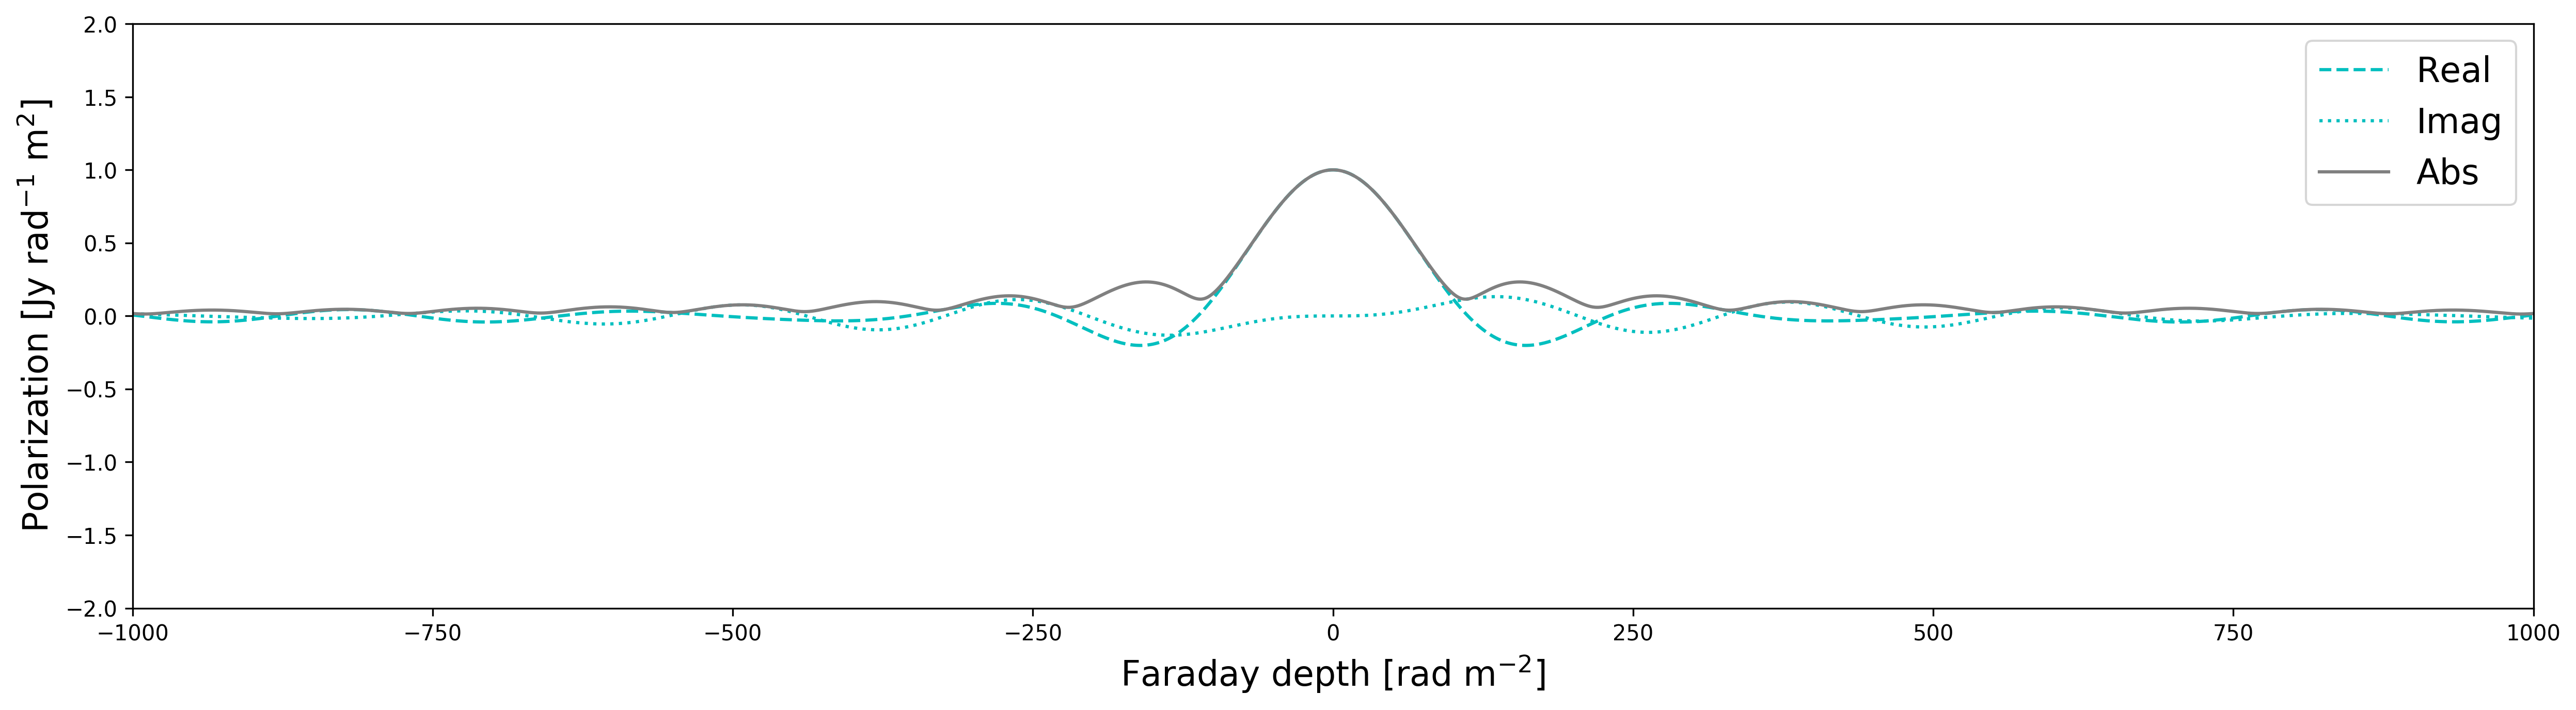

('RMTF FWHM: ', 134.6134613461345, ' rad/m^2')
('Decimation factor: ', 673.0673067306725)


In [17]:
pl.subplot(111)
pl.plot(phi,np.real(rmtf),ls='--',c='c',label="Real")
pl.plot(phi,np.imag(rmtf),ls=':',c='c',label="Imag")
pl.plot(phi,np.abs(rmtf),ls='-',c='grey',label="Abs")
pl.xlim(-1000,1000)
pl.ylim(-2,2)
pl.ylabel(r"Polarization [Jy rad$^{-1}$ m$^2$]", fontsize=16)
pl.xlabel(r"Faraday depth [rad m$^{-2}$]", fontsize=16)
pl.legend(fontsize=16)
pl.show()

fwhm = 2.*phi[np.argmin(np.abs(np.abs(rmtf)-0.5))]
pix = 2000./10000.

print("RMTF FWHM: ",fwhm," rad/m^2")
print("Decimation factor: ", fwhm/pix)

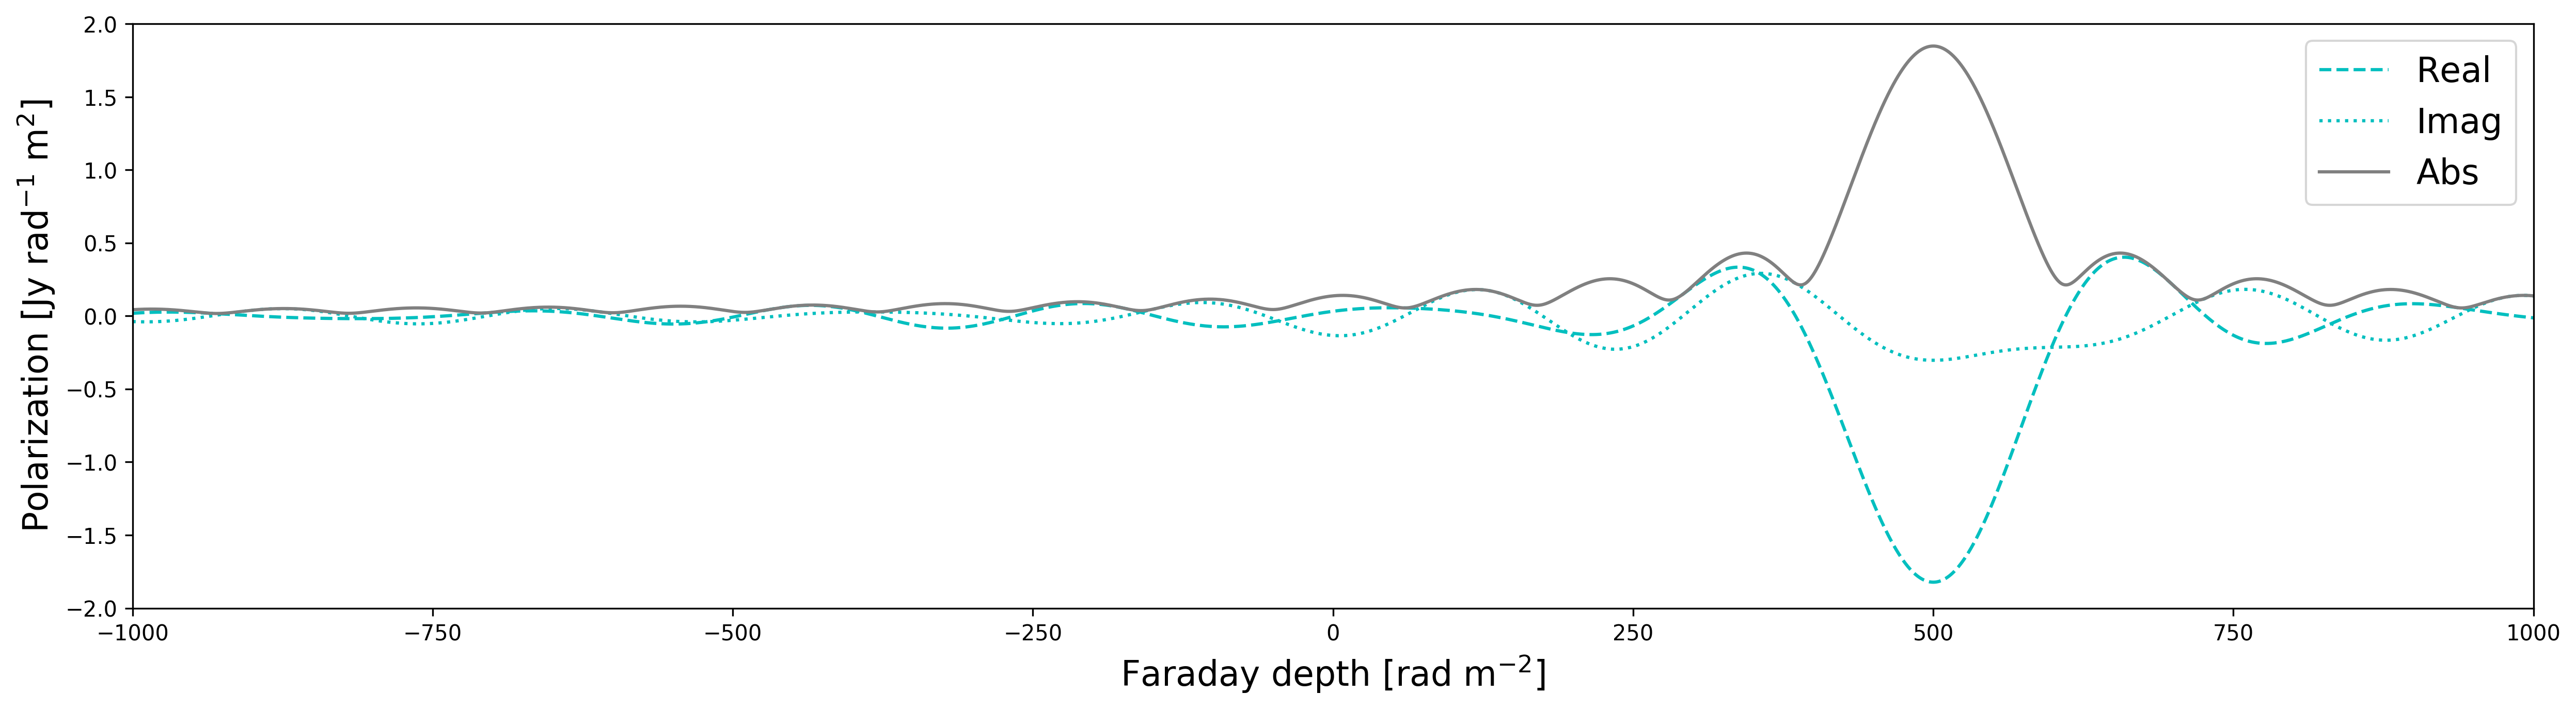

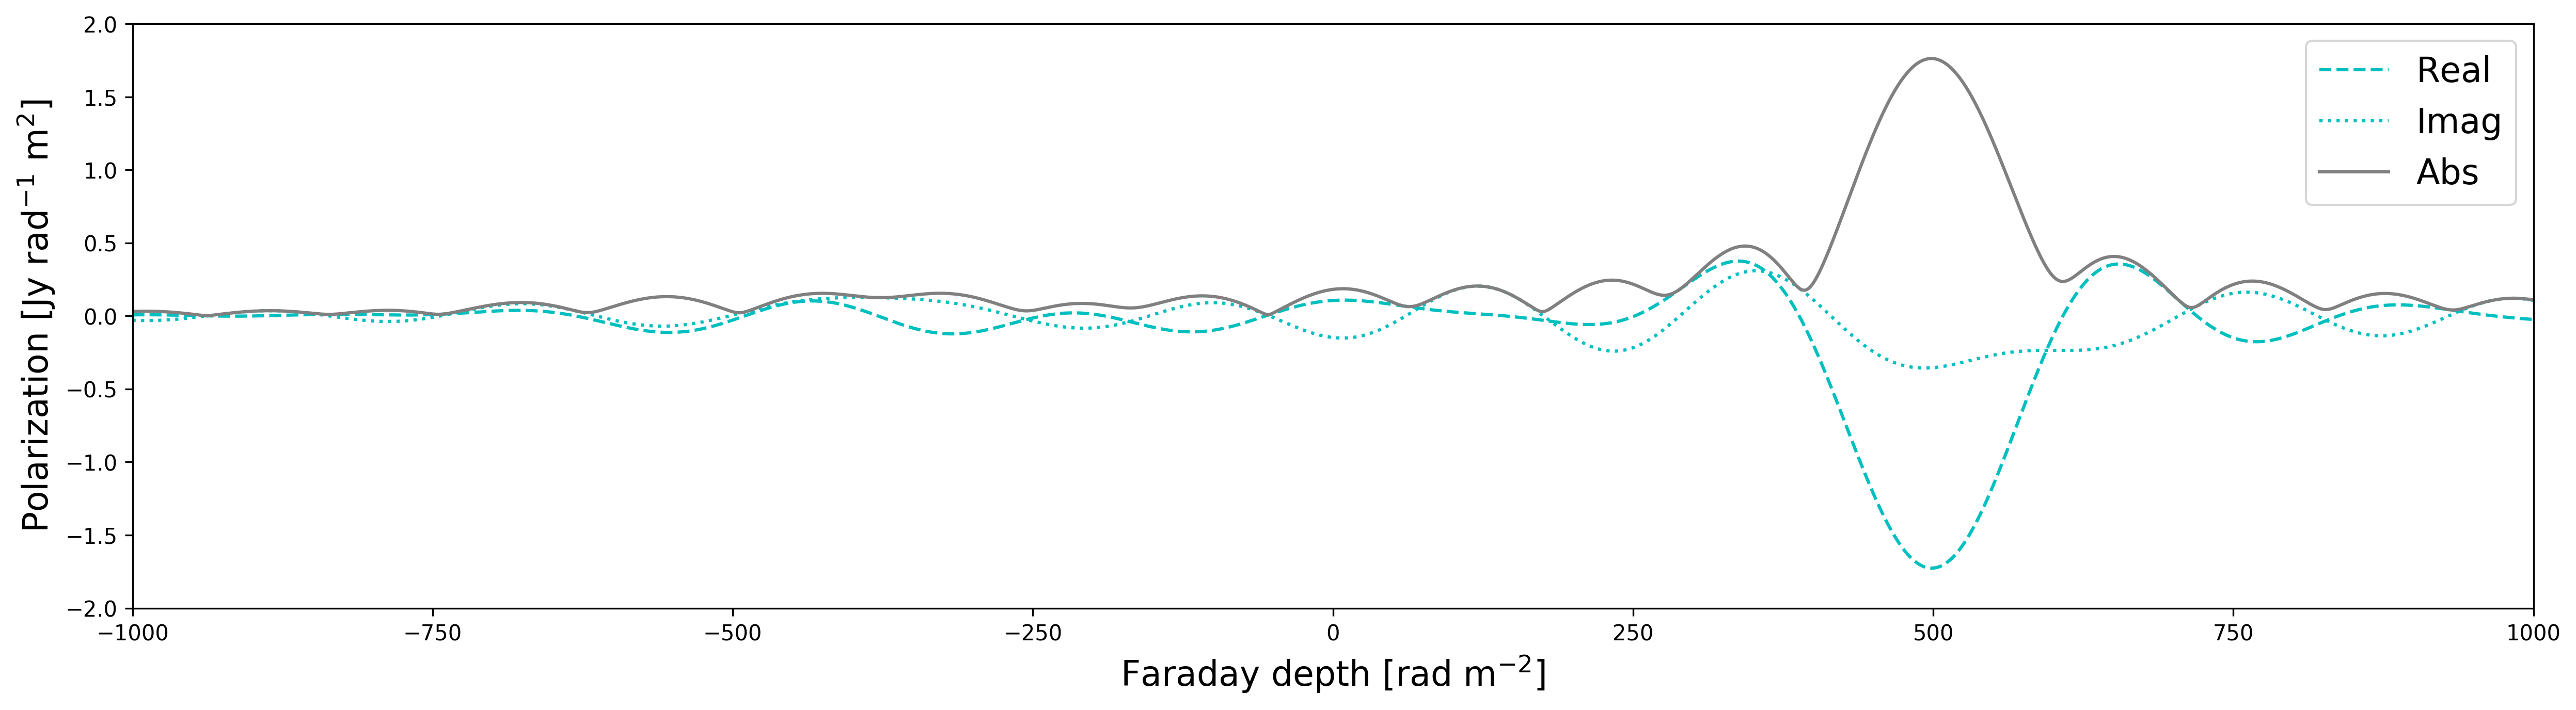

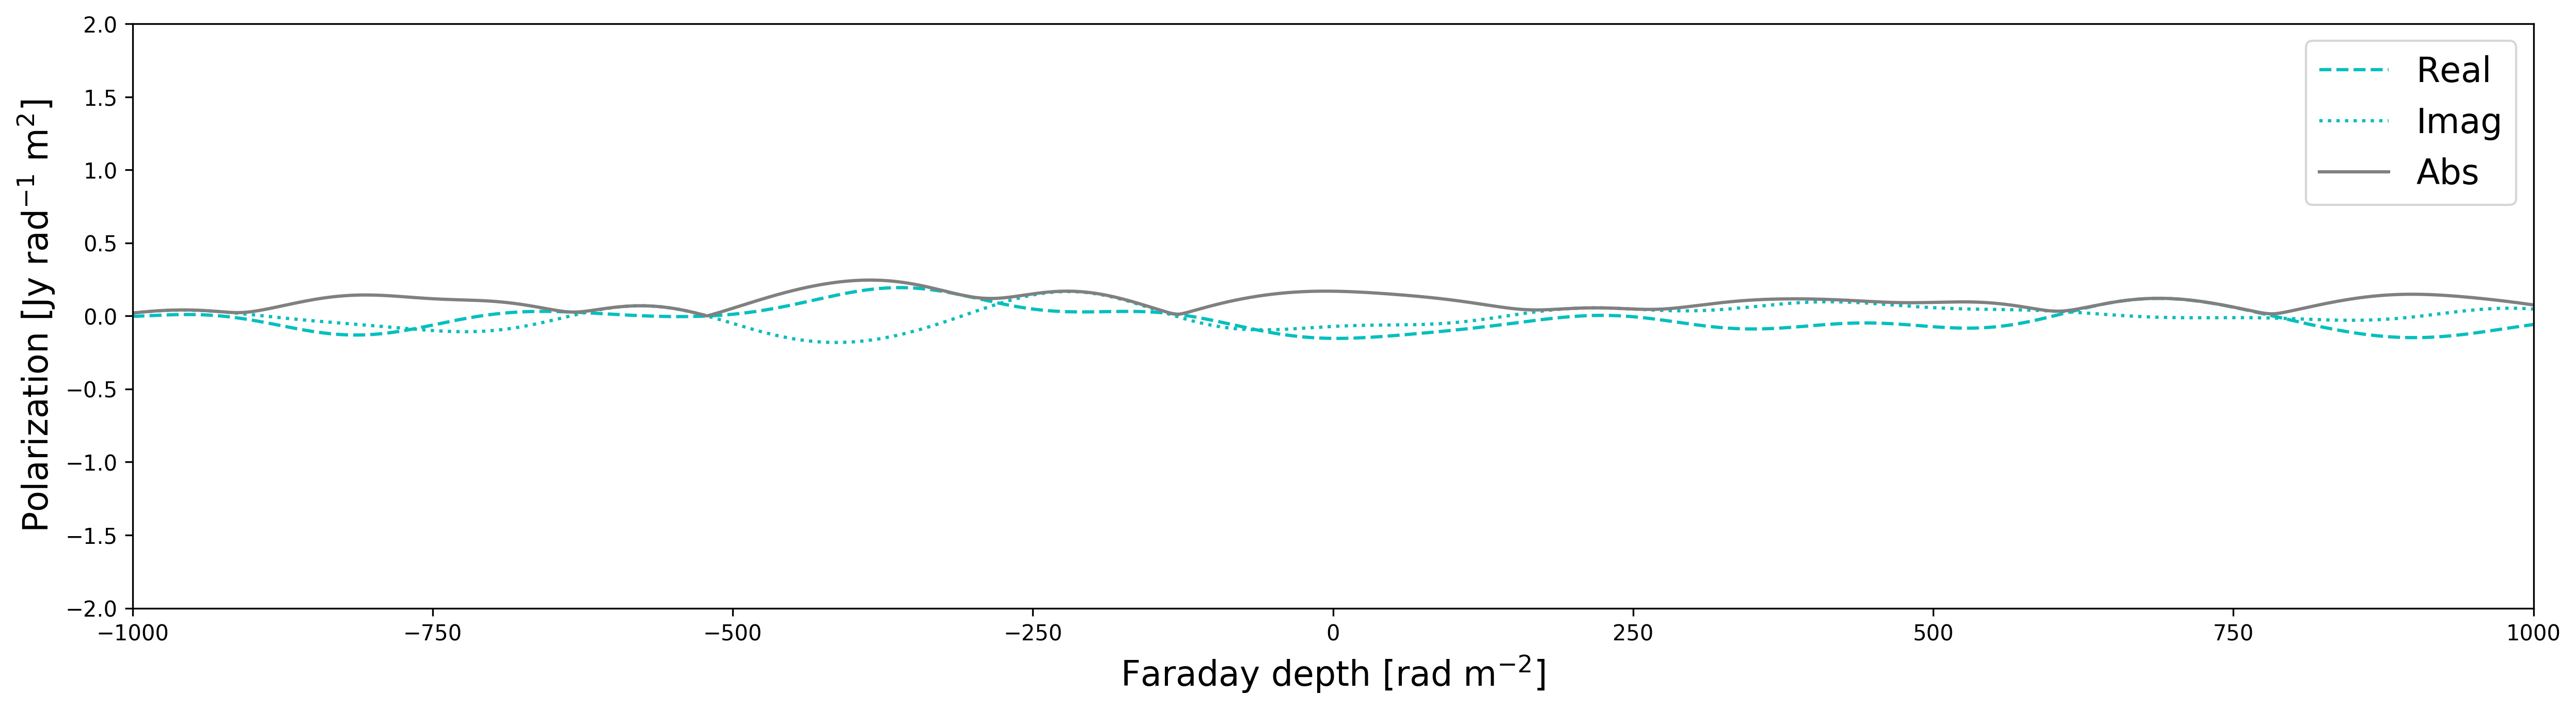

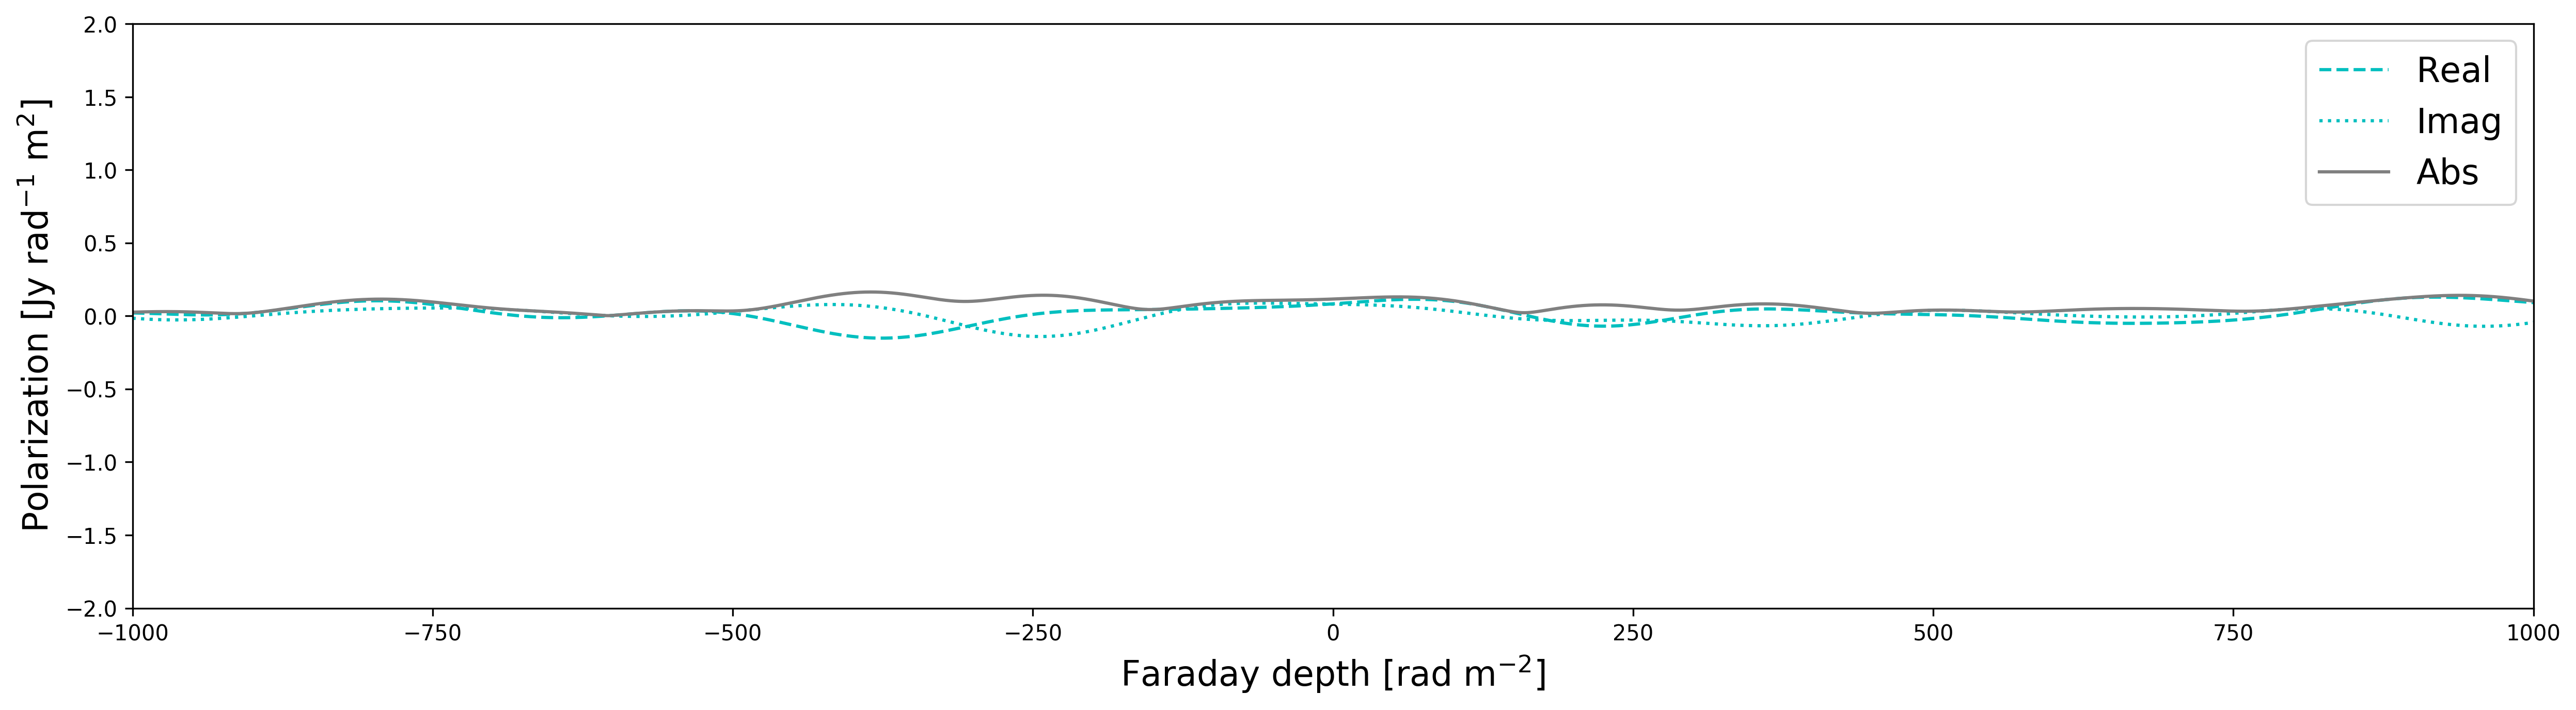

In [19]:
pl.subplot(111)
pl.plot(phi,np.real(fspec_true),ls='--',c='c',label="Real")
pl.plot(phi,np.imag(fspec_true),ls=':',c='c',label="Imag")
pl.plot(phi,np.abs(fspec_true),ls='-',c='grey',label="Abs")
pl.xlim(-1000,1000)
pl.ylim(-2,2)
pl.ylabel(r"Polarization [Jy rad$^{-1}$ m$^2$]", fontsize=16)
pl.xlabel(r"Faraday depth [rad m$^{-2}$]", fontsize=16)
pl.legend(fontsize=16)
pl.show()
pl.subplot(111)
pl.plot(phi,np.real(fspec_gp),ls='--',c='c',label="Real")
pl.plot(phi,np.imag(fspec_gp),ls=':',c='c',label="Imag")
pl.plot(phi,np.abs(fspec_gp),ls='-',c='grey',label="Abs")
pl.xlim(-1000,1000)
pl.ylim(-2,2)
pl.ylabel(r"Polarization [Jy rad$^{-1}$ m$^2$]", fontsize=16)
pl.xlabel(r"Faraday depth [rad m$^{-2}$]", fontsize=16)
pl.legend(fontsize=16)
pl.show()
pl.subplot(111)
pl.plot(phi,np.real(fspec1),ls='--',c='c',label="Real")
pl.plot(phi,np.imag(fspec1),ls=':',c='c',label="Imag")
pl.plot(phi,np.abs(fspec1),ls='-',c='grey',label="Abs")
pl.xlim(-1000,1000)
pl.ylim(-2,2)
pl.ylabel(r"Polarization [Jy rad$^{-1}$ m$^2$]", fontsize=16)
pl.xlabel(r"Faraday depth [rad m$^{-2}$]", fontsize=16)
pl.legend(fontsize=16)
pl.show()

---
### Loop through models

In [21]:
nmodel = 17

In [22]:
model_chi2r = []
phi = np.linspace(-1000,1000,10000)

model_msll = []; model_smse = []; model_chi2r = []; model_smse1 = []

for model in tqdm_notebook(range(nmodel)):
    
    # -------------------------------------------------------------------------------------------
    # DATA CREATION
    
    # make the model:
    p = make_model(model,l2)
    
    # normalise the model:
    pI = np.mean(np.sqrt(np.real(p)**2+np.imag(p)**2))
    snr = pI*np.sqrt(len(l2))
    f_snr = 32./snr
    p*=f_snr
    
    # add the noise to Q & U: 
    noise = 1.0
    stokesQn = np.real(p)+np.random.normal(loc =0.0, scale=noise, size = len(p))
    stokesUn = np.imag(p)+np.random.normal(loc =0.0, scale=noise, size = len(p))
    
    # -------------------------------------------------------------------------------------------
    # GP MODELLING
    
    # optimize hyper-parameters of GP and make a prediction:
    GP = MyCelerite(noise)
    GP.celerite_optimize(l2, stokesQn, stokesUn)
    mu_q, std_q, mu_u, std_u = GP.celerite_predict(stokesQn, stokesUn, l2[::-1])

    # calculate the variance for the model:
    # calculate the variance for the model:
    c_q = std_q**2+noise*np.ones(len(std_q))
    c_u = std_u**2+noise*np.ones(len(std_u))    

    gp_var = std_q**2+noise*np.ones(len(std_q))
    
    # -------------------------------------------------------------------------------------------
    # PERFORMANCE METRIC EVALUATION
    
    # create complex stokes:
    stokes = (stokesQn+1j*stokesUn)[::-1]
    
    # calculate CHI2, SMSE, MSLL metrics from Sun et al 2010 paper:
    chi2_r = calc_chi2_r(stokes,mu_q+1j*mu_u,noise*np.ones(len(std_q)))
    smse   = calc_smse(stokes,mu_q+1j*mu_u,noise*np.ones(len(std_q)))
    msll   = calc_sll(stokes,mu_q+1j*mu_u,gp_var)
    

    # -------------------------------------------------------------------------------------------
    # FARADAY METRIC EVALUATION
    
    T = 100
    sum_diff = 0.
    
    smse1, smse2 = [], []
    
    for i in range(T):

        fspec1, fspec2 = [], []

        eps1 = np.random.normal(0, 1, size=len(mu_q))
        eps2 = np.random.normal(0, 1, size=len(mu_u))

        q_pred = mu_q + np.sqrt(c_q)*eps1
        u_pred = mu_u + np.sqrt(c_u)*eps2

        q_noise = np.sqrt(c_q)*eps1
        u_noise = np.sqrt(c_u)*eps2

        q_diff = np.real(p)[::-1] - q_pred
        u_diff = np.imag(p)[::-1] - u_pred

        w_gp = 2./(c_q + c_u)

        for i in range(0,len(phi)):
            fspec1.append(calc_f(phi[i],l2[::-1],q_diff,u_diff,w_gp))
            fspec2.append(calc_f(phi[i],l2[::-1],q_noise,u_noise,w_gp))

        fspec1 = np.array(fspec1)
        fspec2 = np.array(fspec2)
        
        fspec1_dec = fspec1[::700].copy()
        fspec2_dec = fspec2[::700].copy()
        
        smse_diff1 = (1./(2*len(fspec1_dec)))*np.sum(np.real(fspec1_dec)**2 + np.imag(fspec1_dec)**2)/fnoise**2
        smse_diff2 = (1./(2*len(fspec2_dec)))*np.sum(np.real(fspec2_dec)**2 + np.imag(fspec2_dec)**2)/fnoise**2


        smse1.append(smse_diff1)
        smse2.append(smse_diff2)
        
    smse1 = np.mean(np.array(smse1))
    smse2 = np.mean(np.array(smse2))
        
    # -------------------------------------------------------------------------------------------
    # UPDATE OUTPUTS
    
    model_smse.append(smse)
    model_msll.append(msll)
    model_chi2r.append(chi2_r)
    model_smse1.append(smse1)
    

Model N:       CHI2       SMSE       MSLL      SMSE1      SMSE2 
Model 0: 0.879689700465 0.873825102462 -1.4645668919 1.61733872852 1.0574380833 
Model 1: 0.995513053931 0.988876300238 -0.935061450191 1.30809199876 1.07467131384 
Model 2: 1.05585568633 1.04881664842 -0.474937980641 1.00713913577 0.989358768354 
Model 3: 1.03370058214 1.02680924493 -0.991241004205 1.33449060466 1.06281377995 
Model 4: 0.958894980122 0.952502346921 -0.705275746593 1.17741939347 0.982020645672 
Model 5: 1.04516618841 1.03819841382 -0.801150830893 1.15787792423 1.00765823167 
Model 6: 1.08151704512 1.07430693149 -0.505269597498 1.27736327446 1.03818707998 
Model 7: 1.04158559107 1.03464168713 -1.26652612439 1.3031433929 1.05457590046 
Model 8: 0.906390139651 0.90034753872 -0.720845019879 1.05410590016 1.01155421355 
Model 9: 1.05425335701 1.0472250013 -0.903914542235 1.27478236378 1.0864482689 
Model 10: 1.10144669767 1.09410371968 -1.33884246352 1.32598444343 1.04112067445 
Model 11: 1.02894894387 1.02208

In [36]:
print("Model {: >3}: {: >6} {: >6} {: >7} {: >7}".format("N","CHI2","SMSE","MSLL","SMSE1"))
for i in range(17):
    print("Model {: >3}: & {:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\".format(i+1,model_chi2r[i],model_smse[i],model_msll[i],model_smse1[i]))

Model   N:   CHI2   SMSE    MSLL   SMSE1
Model   1: & 0.88 & 0.87 & -1.46 & 1.62 \\
Model   2: & 1.00 & 0.99 & -0.94 & 1.31 \\
Model   3: & 1.06 & 1.05 & -0.47 & 1.01 \\
Model   4: & 1.03 & 1.03 & -0.99 & 1.33 \\
Model   5: & 0.96 & 0.95 & -0.71 & 1.18 \\
Model   6: & 1.05 & 1.04 & -0.80 & 1.16 \\
Model   7: & 1.08 & 1.07 & -0.51 & 1.28 \\
Model   8: & 1.04 & 1.03 & -1.27 & 1.30 \\
Model   9: & 0.91 & 0.90 & -0.72 & 1.05 \\
Model  10: & 1.05 & 1.05 & -0.90 & 1.27 \\
Model  11: & 1.10 & 1.09 & -1.34 & 1.33 \\
Model  12: & 1.03 & 1.02 & -1.47 & 1.41 \\
Model  13: & 0.99 & 0.98 & -0.58 & 1.17 \\
Model  14: & 0.87 & 0.87 & -1.41 & 1.59 \\
Model  15: & 1.07 & 1.06 & -1.35 & 1.16 \\
Model  16: & 0.99 & 0.98 & -1.53 & 1.25 \\
Model  17: & 1.02 & 1.01 & -1.41 & 1.20 \\


---
### Make plot:

In [37]:
pl.rcParams['figure.figsize'] = [10, 5]
pl.rcParams['figure.dpi'] = 300

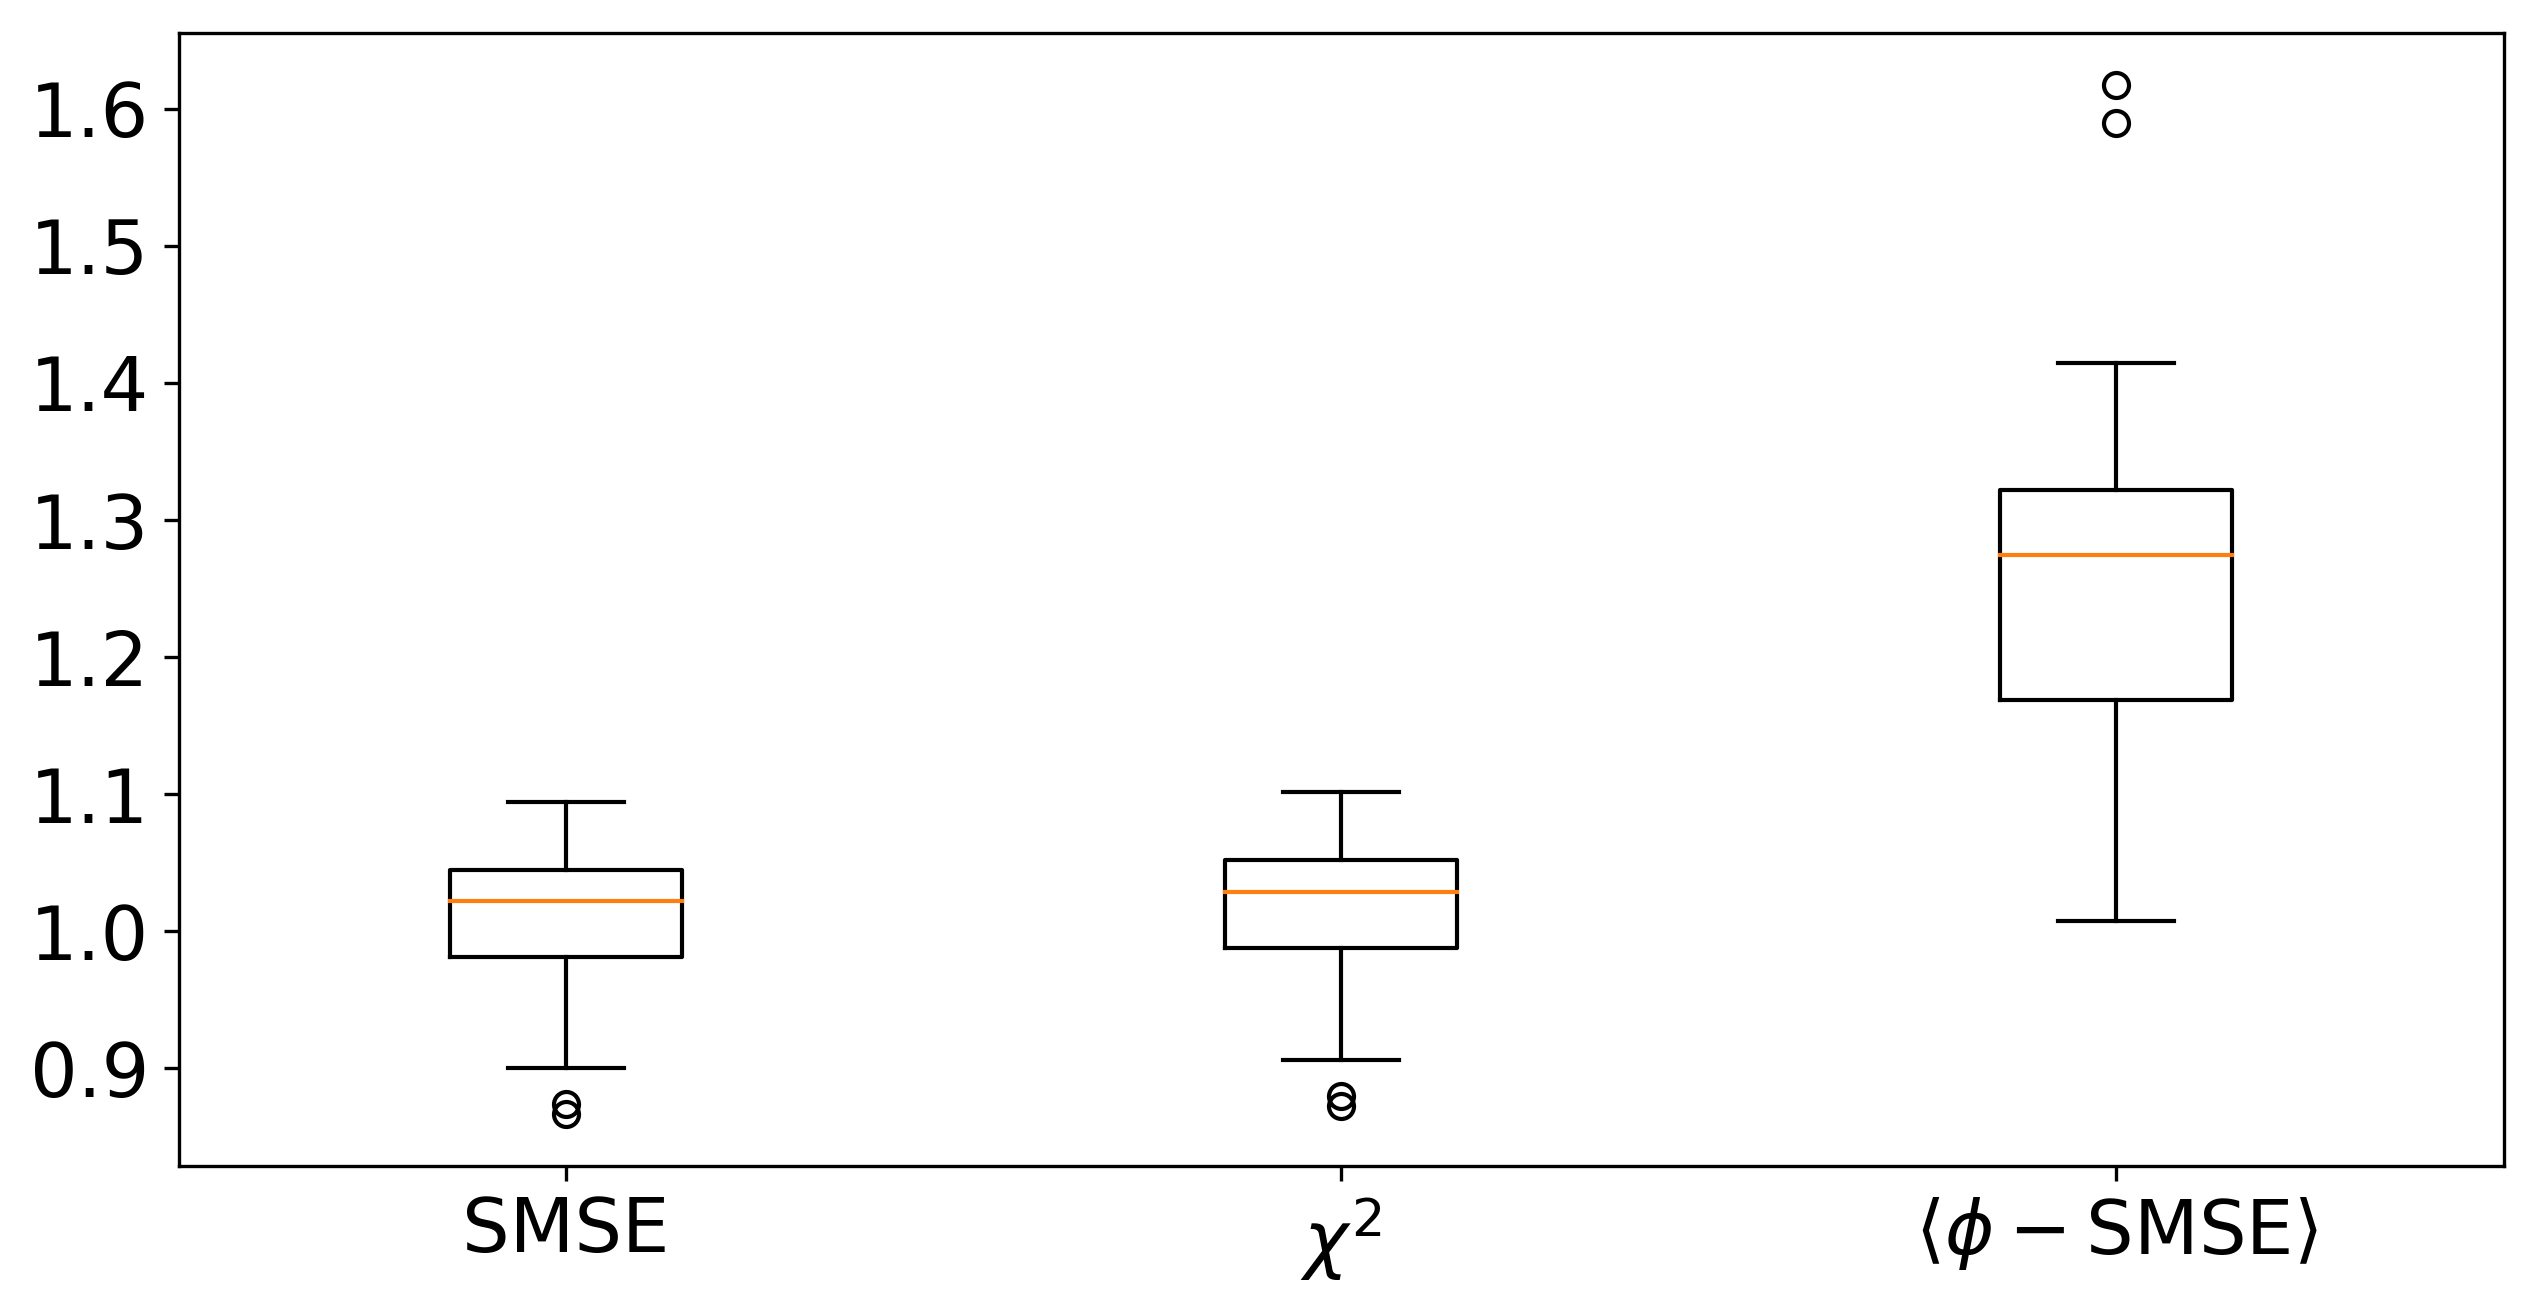

In [39]:
mean_chi2 = [np.median(model_chi2r)]
mean_smse = [np.median(model_smse)]
mean_smse1 = [np.median(model_smse1)]

smsedata = np.concatenate((mean_smse, model_smse))
chi2data = np.concatenate((mean_chi2, model_chi2r))
smse1data = np.concatenate((mean_smse1, model_smse1))

data1 = [smsedata, chi2data, smse1data]

fig1, ax1 = pl.subplots()
ax1.boxplot(data1, showfliers=True)
pl.xticks([1, 2, 3], ['SMSE', r'$\chi^2$', r'$\langle \phi-$SMSE$\rangle$'], fontsize=18)
pl.yticks(fontsize=18)
pl.show()

---
#### END